Create a neural network (using MLP, CNN architectures), in which you will create a classifying model whether an Alien (a creature from a series of sf films initiated by Ridley Scott's film *Aliens. The Eighth Passenger of Nostromo)* or a Predator (a creature from a series initiated by successful films *) appears in the photo Predator 1* and *Predator 2*).

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import traceback

from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc

from flask import Flask, request, render_template

I had at my disposal a database of photos with a predator and an alien, already divided into validation, test and training sets

In [33]:
def data_from_jpg(directory_path):
    image_size = (224, 224)
    image_data = np.zeros((len(os.listdir(directory_path)), image_size[0], image_size[1], 3), dtype=np.uint8)

    for i, filename in enumerate(os.listdir(directory_path)):
        if filename.endswith(".jpg"):
            image = Image.open(os.path.join(directory_path, filename))
            image = image.resize(image_size)
            np_image = np.array(image)
            if len(np_image.shape) == 2:
                image_data[i,:,:,:] = np.dstack((np_image,) * 3)
            else:
                image_data[i,:,:,:] = np_image

    return image_data

In [4]:
test_pred = data_from_jpg('alien-vs-predator\\test\\predator')
test_alien = data_from_jpg('alien-vs-predator\\test\\alien')
train_pred = data_from_jpg('alien-vs-predator\\train\\predator')
train_alien = data_from_jpg('alien-vs-predator\\train\\alien')
valid_pred = data_from_jpg('alien-vs-predator\\validation\\predator')
valid_alien = data_from_jpg('alien-vs-predator\\validation\\alien')

In [5]:
#creating the variable y
def y(train_pred, train_alien):
    y_train_1 = np.ones(train_pred.shape[0])
    y_train_2 = np.zeros(train_alien.shape[0])
    y_train = np.concatenate((y_train_1, y_train_2), axis=0)
    return y_train

y_train = y(train_pred, train_alien)
y_test = y(test_pred, test_alien)
y_valid = y(valid_pred, valid_alien)

#joining predator and alien data
X_train = np.concatenate((train_pred, train_alien), axis=0)
X_test = np.concatenate((test_pred, test_alien), axis=0)
X_valid = np.concatenate((valid_pred, valid_alien), axis=0)

#normalization
X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

In [11]:
#training model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


batch_size = 128
epochs = 10
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
6/6 [==============================] - 10s 2s/step - loss: 3.1175 - accuracy: 0.5187 - val_loss: 4.7743 - val_accuracy: 0.5000
Epoch 2/10
6/6 [==============================] - 10s 2s/step - loss: 2.6731 - accuracy: 0.5360 - val_loss: 1.8993 - val_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 10s 2s/step - loss: 1.0745 - accuracy: 0.6066 - val_loss: 1.3213 - val_accuracy: 0.5659
Epoch 4/10
6/6 [==============================] - 10s 2s/step - loss: 0.8513 - accuracy: 0.6542 - val_loss: 0.7245 - val_accuracy: 0.5495
Epoch 5/10
6/6 [==============================] - 10s 2s/step - loss: 0.6435 - accuracy: 0.5562 - val_loss: 0.6098 - val_accuracy: 0.6264
Epoch 6/10
6/6 [==============================] - 10s 2s/step - loss: 0.4802 - accuracy: 0.8098 - val_loss: 0.6062 - val_accuracy: 0.6538
Epoch 7/10
6/6 [==============================] - 10s 2s/step - loss: 0.4653 - accuracy: 0.8242 - val_loss: 0.5451 - val_accuracy: 0.7582
Epoch 8/10
6/6 [==================

1/1 [==============================] - 0s 72ms/step


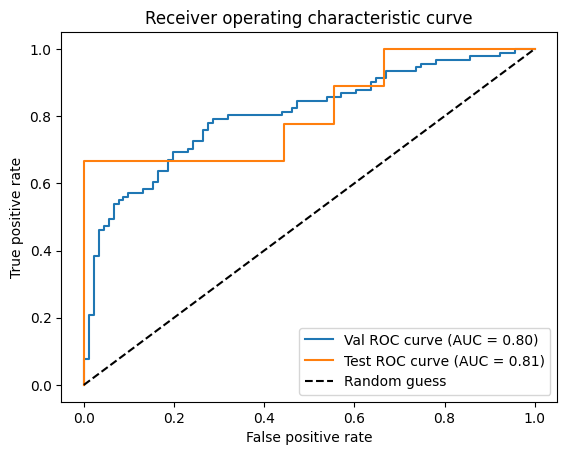

In [16]:
# Predictions for val and test
y_pred_val = model.predict(X_valid)
y_pred_test = model.predict(X_test)

# ROC
fpr_val, tpr_val, thresholds_val = roc_curve(y_valid, y_pred_val)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)

# AUC
auc_val = auc(fpr_val, tpr_val)
auc_test = auc(fpr_test, tpr_test)

# Wykres
plt.plot(fpr_val, tpr_val, label=f'Val ROC curve (AUC = {auc_val:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend()
plt.show()

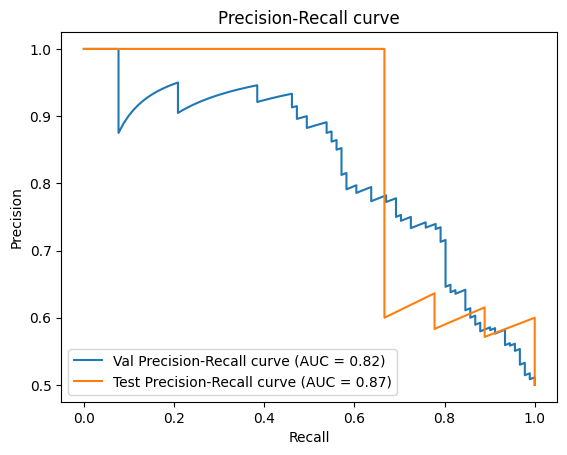

In [14]:
# Precision-Recall
precision_val, recall_val, thresholds_val = precision_recall_curve(y_valid, y_pred_val)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test)

# AUC
auc_val = auc(recall_val, precision_val)
auc_test = auc(recall_test, precision_test)

# Wykres
plt.plot(recall_val, precision_val, label=f'Val Precision-Recall curve (AUC = {auc_val:.2f})')
plt.plot(recall_test, precision_test, label=f'Test Precision-Recall curve (AUC = {auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

I have included the model file in the repository

In [18]:
model.save('model.h5')

Basic flask app to predict if a picture is an alien or a predator

Run it and put a picture of a predator or alien

In [32]:
app = Flask(__name__)
model = keras.models.load_model('model.h5')  

@app.route('/')
def home():
    return render_template_string('''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Image Classification</title>
    </head>
    <body>
        <h1>Image Classification</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="image" accept="image/*" required>
            <input type="submit" value="Predict">
        </form>
    </body>
    </html>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    image = request.files['image']

    img = Image.open(image)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0

    predictions = model.predict(np.expand_dims(img, axis=0))

    if predictions[0][0] > 0.5:
        result = 'Its probably PREDATOR'
    else:
        result = 'Its probably ALIEN'

    return render_template_string('''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Result</title>
    </head>
    <body>
        <h1>Result</h1>
        <p>{{ result }}</p>
        <a href="/">Once again</a>
    </body>
    </html>
    ''', result=result)

if __name__ == '__main__':
    app.run(port=8080)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8080
Press CTRL+C to quit
127.0.0.1 - - [11/May/2023 16:12:21] "GET / HTTP/1.1" 200 -
